In [ ]:
# ПАРСИНГ

In [ ]:
import requests as req
import re
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup

In [ ]:
#в этой части меняете даты на желаемые
all_dates = [] #список с нулевыми данными, чтобы записать туда то, что мы хотим
datelist = pd.date_range(start = '12.01.2020', end = '12.31.2020', inclusive="both") #возвращает список в диапазоне этих дат
d = datelist.values.astype('<M8[D]').astype(str) #формат даты задается
for i in d:
    i = re.findall('[0-9]+', i)
    all_dates.append(''.join(i))

print(all_dates)

['20201201', '20201202', '20201203', '20201204', '20201205', '20201206', '20201207', '20201208', '20201209', '20201210', '20201211', '20201212', '20201213', '20201214', '20201215', '20201216', '20201217', '20201218', '20201219', '20201220', '20201221', '20201222', '20201223', '20201224', '20201225', '20201226', '20201227', '20201228', '20201229', '20201230', '20201231']


In [ ]:
#выбираете любой из links для всех категорий или той, которая нужна

links = {"health": []}

for i in all_dates:
    for key in links:
        links[key].append("https://ria.ru/services/" + key + "/more.html?id=1862588907&date=" + i )

few_pages_links = [link for key in links for link in links[key]]
few_pages_links

['https://ria.ru/services/health/more.html?id=1862588907&date=20201201',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201202',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201203',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201204',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201205',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201206',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201207',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201208',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201209',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201210',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201211',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201212',
 'https://ria.ru/services/health/more.html?id=1862588907&date=20201213',
 'https://ria.ru/services/health/more.html?id=18625

In [ ]:
all_links = []
all_views = []

for link in few_pages_links:
    r = req.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')
    links = soup.findAll("a", class_ = "list-item__title")
    views = soup.findAll('div', class_="list-item__views-text")
    for my_href in links:
        all_links.append(my_href.get("href"))
        #print(my_href.get("href"))
    for view in views:
        all_views.append(view.text)


In [ ]:
info = []

for link in all_links:

    response = req.get(link)
    soup1 = BeautifulSoup(response.text, 'html.parser')

    extracted_text = ''.join([i.text for i in soup1.findAll("div", class_="article__text")])
    text = re.sub('^([^.]\D+[^.]+\.\s)', "", extracted_text)

    date = soup1.find("div", class_= "article__info-date").text
    time, date = date[:16].split(' ')[0], date[:16].split(' ')[1]

    article_tags = soup1.find("div", class_="article__tags")
    tags = [tag.text for tag in article_tags.find_all("a", class_="article__tags-item")] if article_tags else []

    title_div = soup1.find("div", class_="article__title")
    title_h1 = soup1.find("h1", class_="article__title")

    if title_div or title_h1:
        title = title_div.text.strip() if title_div else title_h1.text.strip()
        lead = soup1.find("h1", class_="article__second-title").text.strip() if soup1.find("h1", class_="article__second-title") else ""
        print(link, title, lead, text, time, date, tags, sep = "\n")
        info.append({"url": link, "title": title, "lead": lead, "text": text, "time": time, "date": date, "tags": tags})
    else:
        info.append({"url": link, "title": None, "lead": None, "text": None, "time": None, "date": None, "tags": None})



In [ ]:
import pandas as pd
df = pd.DataFrame(info)
#df['views'] = all_views
df.isna().mean()
df

In [ ]:
df['text'].isna().sum()

0

In [ ]:
import numpy as np
print(df.loc[df['text'].isnull()])

Empty DataFrame
Columns: [url, title, lead, text, time, date, tags]
Index: []


In [ ]:
final_df = df.drop(index = [])

In [ ]:
final_df['text'].isna().sum()

0

In [ ]:
words = ['ковид','коронавирус','covid','covid-19', 'корона', 'пандемия']
new_df = final_df[final_df['text'].str.contains('|'.join(words), case = False)]
new_df

,url,title,lead,text,time,date,tags
0,https://ria.ru/20201201/perepalka-1587256663.html,Баста и Шнуров обменялись оскорблениями из-за ...,,Сергей Шнуров и Баста (Василий Вакуленко) пору...,23:44,01.12.2020,"[Общество, Соцсети, Шнур (Сергей Шнуров), Баст..."
1,https://ria.ru/20201201/koronavirus-1587254634...,В Москве число умерших пациентов с коронавирус...,,"Количество пациентов, скончавшихся в Москве от...",23:02,01.12.2020,"[Распространение коронавируса, Москва, Здоровь..."
2,https://radiosputnik.ria.ru/20201201/malysheva...,Риск смерти выше. Малышева напомнила о болезня...,,"Врач-терапевт, доктор медицинских наук, ведуща...",21:34,01.12.2020,"[Общество, Здоровье - Общество, инфаркты, Инсу..."
3,https://radiosputnik.ria.ru/20201201/restoran-...,А нам все равно. В Удмуртии разрешат отмечать ...,,Жителям Удмуртии дадут возможность проводить к...,20:06,01.12.2020,"[Общество, Москва, Сергей Собянин, Федеральная..."
4,https://ria.ru/20201201/vyplaty-1587230353.html,Самарские медики получат выплаты за работу с C...,,Губернатор Самарской области Дмитрий Азаров по...,19:32,01.12.2020,"[Общество, Самарская область, Дмитрий Азаров, ..."
...,...,...,...,...,...,...,...
615,https://ria.ru/20201231/koronavirus-1591687332...,Оперштаб объяснил разницу в данных по смертнос...,,Оперштаб объяснил разницу в данных по смертнос...,11:06,31.12.2020,"[Распространение коронавируса, Здоровье - Обще..."
616,https://ria.ru/20201231/koronavirus-1591686474...,В России выявили 27 747 новых случаев коронави...,,За минувшие сутки в России выявили 27 747 новы...,11:01,31.12.2020,"[Распространение коронавируса, Общество, Здоро..."
617,https://ria.ru/20201231/antitela-1591686199.html,Гинцбург рассказал о препарате для лечения COV...,,Препарат на основе антител для лечения COVID-1...,10:54,31.12.2020,"[Распространение коронавируса, Здоровье - Обще..."
618,https://ria.ru/20201231/medstranitsy-159168155...,"В российских паспортах могут появиться ""медстр...",,Первый замглавы общественной палаты Ленинградс...,10:05,31.12.2020,"[Общество, Ленинградская область, Здоровье - О..."


In [ ]:
# экспорт
new_df.to_csv (r'COV_12.csv', index=False, encoding="UTF-8")

In [ ]:
# ПРЕДОБРАБОТКА: ТОКИНЕНИЗАЦИЯ, ЛЕММАТИЗАЦИЯ

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
#import spacy
import string

In [ ]:
##Чтение датасета с текстом
df = pd.read_csv("2020.csv", encoding='cp1251', sep=",")
df.head()


UnicodeDecodeError: ignored

In [ ]:
#help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers.readers:

read_csv(filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]', sep=<no_default>, delimiter=None, header='infer', names=<no_default>, index_col=None, usecols=None, squeeze=None, prefix=<no_default>, mangle_dupe_cols=True, dtype: 'DtypeArg | None' = None, engine: 'CSVEngine | None' = None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=None, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression: 'CompressionOptions' = 'infer', thousands=None, decimal: 'str' = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, encoding_errors: 'str | None' = 'strict', dialect=None, error_bad_li

In [ ]:
from nltk.corpus import stopwords
with open("stopwords.txt", 'r', encoding="utf8") as f:
    STOPWORDS = f.read().splitlines()

# функция, удаляющая стопслова из текстов
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# Удаление эмодзи
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
#Удаление URL
# Function for url's
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
from bs4 import BeautifulSoup
#Function for removing html
def html(text):
    return BeautifulSoup(text, "lxml").text
#Можно выполнить при помощи NLTK. Заодно проведем лемматизацию
from pymorphy2 import MorphAnalyzer
from nltk import sent_tokenize, word_tokenize, regexp_tokenize

def tokenize_lemmas(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):
    return [morph.parse(tok)[0].normal_form
            for tok in regexp_tokenize(sent, pat)]

In [ ]:
df['text_ready']  = df['Text'].str.lower()
df['text_ready'] = df['text_ready'].str.replace('\d+', '')
df['text_ready'] = df['text_ready'].str.replace('[^\w\s]','')
df["text_ready"] = df["text_ready"].apply(stopwords)
df['text_ready'] = df['text_ready'].apply(emoji)
df['text_ready'] = df['text_ready'].apply(remove_urls)
df['text_ready'] = df['text_ready'].apply(html)
df["text_ready"] = df["text_ready"].map(lambda x: " ".join(tokenize_lemmas(x)))
df[['text_ready']].head()

C:\Users\Катя\AppData\Local\Temp\ipykernel_4416\2591792495.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text_ready'] = df['text_ready'].str.replace('\d+', '')
C:\Users\Катя\AppData\Local\Temp\ipykernel_4416\2591792495.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text_ready'] = df['text_ready'].str.replace('[^\w\s]','')


,text_ready
0,власть марокко принять решение продлить июль р...
1,власть марокко вводить режим чрезвычайный ситу...
2,профилактический самолечение антивирусный преп...
3,китай выявить новый случай заражение коронавир...
4,количество умерший коронавирус китайский прови...


In [ ]:
# WORD EMBEDDING: ОБУЧАЕМ МОДЕЛЬ

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [ ]:
#help(Word2Vec)

In [ ]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=5,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)
#min_count — минимальное число вхождений слова
#window — расстояние между current и predicted слов
#vector_size — размер векторного представления слова (word embedding) — размер матрицы
#negative — сколько неконтекстных слов учитывать в обучении, используя negative sampling — число слов
#alpha — начальный learning_rate, используемый в алгоритме обратного распространения ошибки (Backpropogation).Задаем угол наклон распределения
#min_alpha — минимальное значение learning_rate, на которое может опуститься в процессе обучения.
#sg — если 1, то используется реализация Skip-gram; если 0, то CBOW.

In [ ]:
#Получаем лист слов
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess

class MySentences(object):
    def __init__(self, docs):
        self.corpus = docs
    def __iter__(self):
        for doc in self.corpus:
            doc_sentences = sent_tokenize(doc)
            for sent in doc_sentences:
                yield simple_preprocess(sent) # yields a tokenized

In [ ]:
sentences = MySentences(df['text_ready'].tolist())

In [ ]:
#Получаем словарь
w2v_model.build_vocab(sentences)

In [ ]:
#Обучение
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=6, report_delay=1)

(2128542, 4316130)

In [ ]:
#для сохранения оперативной памяти можно написать следующее
w2v_model.init_sims(replace=True)

C:\Users\Катя\AppData\Local\Temp\ipykernel_4416\232342886.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [ ]:
# TF-IDF (КЛЮЧЕВЫЕ СЛОВА)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True)

In [ ]:
texts = df.text_ready
texts

0       власть марокко принять решение продлить июль р...
1       власть марокко вводить режим чрезвычайный ситу...
2       профилактический самолечение антивирусный преп...
3       китай выявить новый случай заражение коронавир...
4       количество умерший коронавирус китайский прови...
                              ...                        
1457    посольство россия италия предупредить власть с...
1458    александр логун вернуть турист венеция помочь ...
1459    александр логун лечение онкологический заболев...
1460    полицейский ранить беспорядок улица белград вы...
1461    александр логун транзит груз оранжевый зона ре...
Name: text_ready, Length: 1462, dtype: object

In [ ]:
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(texts)

In [ ]:
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

In [ ]:
df1 = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df1.sort_values(by=["tfidf"],ascending=False)[:10]

,tfidf
чп,0.534616
проживание,0.188707
ввести,0.161370
продлить,0.143001
санитарный,0.141172
июль,0.139845
смягчать,0.138685
полученномзаявление,0.136890
рамка,0.135464
тюремный,0.135218


In [ ]:
# СИНОНИМИЧЕСКАЯ БЛИЗОСТЬ

In [ ]:
w2v_model.wv.most_similar(positive=["санитарный"], topn=10)

[('почтовый', 0.8879984617233276),
 ('норма', 0.8644577860832214),
 ('гуманитарный', 0.8586306571960449),
 ('грузовой', 0.85755455493927),
 ('перегон', 0.8085454106330872),
 ('предписание', 0.8063254952430725),
 ('требование', 0.7898478507995605),
 ('перелёт', 0.7806081175804138),
 ('вывозной', 0.7716246843338013),
 ('осуществляться', 0.7715108394622803)]

In [ ]:
w2v_model.wv.most_similar(positive=["санитарный", "июль", "чп"], topn=10)

[('круглосуточный', 0.9280354380607605),
 ('график', 0.9258958697319031),
 ('продлеваться', 0.9166024327278137),
 ('продлевать', 0.9161745309829712),
 ('госуслуга', 0.9105709791183472),
 ('плановый', 0.9087097644805908),
 ('камчатка', 0.905164361000061),
 ('ереван', 0.9018957018852234),
 ('доминиканский', 0.8999549746513367),
 ('превентивный', 0.899520993232727)]

In [ ]:
#Векторы можно складывать и вычитать. Например, рассмотрим такой вариант: “товар” + “продавец” — “ужасный”:
w2v_model.wv.most_similar(positive=["чп", "ввести"], negative=["тюремный"], topn=10)

[('комендантский', 0.9210173487663269),
 ('чс', 0.8883473873138428),
 ('продлить', 0.8850092887878418),
 ('введение', 0.8832234144210815),
 ('карантинный', 0.8806042671203613),
 ('вводиться', 0.8797508478164673),
 ('ограничительный', 0.8793993592262268),
 ('режим', 0.8781949281692505),
 ('действовать', 0.8756537437438965),
 ('всеобщий', 0.8726568222045898)]

In [ ]:
#определить наиболее близкое слово из списка к данному слово
w2v_model.wv.most_similar_to_given("режим", ["карантинный", "ограничительный", "всеобщий"])

'всеобщий'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def tsne_scatterplot(model, word, list_names):
    """Plot in seaborn the results from the t-SNE dimensionality reduction
    algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    vectors_words = [model.wv.word_vec(word)]
    word_labels = [word]
    color_list = ['red']

    close_words = model.wv.most_similar(word)
    for wrd_score in close_words:
        wrd_vector = model.wv.word_vec(wrd_score[0])
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.word_vec(wrd)
        vectors_words.append(wrd_vector)
        word_labels.append(wrd)
        color_list.append('green')

    # t-SNE reduction
    Y = (TSNE(n_components=2, random_state=0, perplexity=15, init="pca")
        .fit_transform(vectors_words))
    # Sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                    "y": [y for y in Y[:, 1]],
                    "words": word_labels,
                    "color": color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                    x="x",
                    y="y",
                    fit_reg=False,
                    marker="o",
                    scatter_kws={"s": 40,
                                "facecolors": df["color"]}
    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                " " + df["words"][line].title(),
                horizontalalignment="left",
                verticalalignment="bottom", size="medium",
                color=df["color"][line],
                weight="normal"
        ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

C:\Users\Катя\AppData\Local\Temp\ipykernel_4416\3114982501.py:9: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  vectors_words = [model.wv.word_vec(word)]
C:\Users\Катя\AppData\Local\Temp\ipykernel_4416\3114982501.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd_score[0])
C:\Users\Катя\AppData\Local\Temp\ipykernel_4416\3114982501.py:22: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd)
E:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


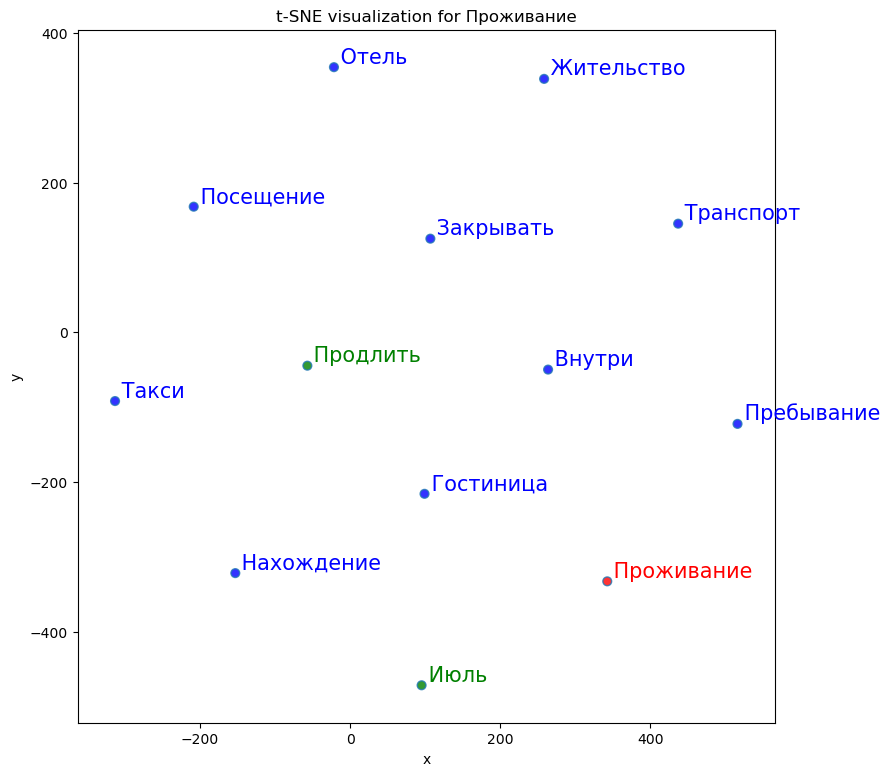

In [ ]:
tsne_scatterplot(w2v_model, "проживание", ["продлить", "июль"])

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model_2020")

In [ ]:
df['text_ready'].to_csv (r'text_ready.csv', index=False, encoding="UTF-8")

In [ ]:
# LDA

In [ ]:
# packages to store and manipulate data
import numpy as np
import pandas as pd
# model building package
import sklearn

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2)

In [ ]:
dtm = cv.fit_transform(df['text_ready'])

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=7,random_state=42)

In [ ]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=7, random_state=42)

In [ ]:
print(len(LDA.components_),type(LDA.components_))

7 <class 'numpy.ndarray'>


In [ ]:
single_topic = LDA.components_[0]
top_10_words = single_topic.argsort()[-10:]

In [ ]:
for index in top_10_words:
    print(cv.get_feature_names_out()[index])

портал
представить
случай
дать
мир
ситуация
регион
коронавирус
россия
covid


In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['медицинский', 'отметить', 'данные', 'правительство', 'ранее', 'заражение', 'май', 'мера', 'пандемия', 'актуальный', 'область', 'режим', 'коронавирусный', 'пациент', 'новый', 'человек', 'число', 'последний', 'инфекция', 'стопкоронавирусрф', 'портал', 'представить', 'случай', 'дать', 'мир', 'ситуация', 'регион', 'коронавирус', 'россия', 'covid']


THE TOP 15 WORDS FOR TOPIC #1
['общий', 'последний', 'организация', 'пневмония', 'находиться', 'подтвердить', 'ситуация', 'пациент', 'сутки', 'воз', 'заразить', 'человек', 'ухань', 'сообщить', 'город', 'covid', 'власть', 'выявить', 'скончаться', 'заболевание', 'провинция', 'вспышка', 'здравоохранение', 'заражение', 'новый', 'страна', 'число', 'китай', 'случай', 'коронавирус']


THE TOP 15 WORDS FOR TOPIC #2
['партия', 'сообщить', 'день', 'принять', 'участник', 'проголосовать', 'пройти', 'избирательный', 'глава', 'регион', 'украина', 'июль', 'коронавирус', 'заявить', 'гражданин', 'акция', 'конституция', 'поправка'

In [ ]:
# BERTopic (РАСПРЕДЕЛЯЕТ БЛИЗКИ ПО ТЕМАТИКЕ СЛОВА В ГРУППЫ)

In [ ]:
!pip install BERTopic

  Using cached bertopic-0.15.0-py2.py3-none-any.whl (143 kB)
  Using cached hdbscan-0.8.29.tar.gz (5.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached sentencepiece-0.1.99-cp39-cp39-win_amd64.whl (977 kB)
  Using cached torchvision-0.15.2-cp39-cp39-win_amd64.whl (1.2 MB)
  Using cached pynndescent-0.5.10-py3-none-any.whl
  Using cached torch-2.0.1-cp39-cp39-win_amd64.whl (172.4 MB)
Failed to build hdbscan


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [40 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\flat.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\hdbscan_.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\plots.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\prediction.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\robust_single_linkage_.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\validity.py -> build\lib.win-amd64-cpython-39\hdbscan
  copying hdbscan\__init__.py -> build\lib.win-amd64-cpython-39\hdbscan
  creating build\lib.win-amd64-cpython-39\hdbscan\tests
  copying hdbscan\tests\test_flat.py -> build\lib.win-amd64-cpython-39\hdbscan\tests
  copying hdbscan\tests\test_hdbscan.py -> build\lib.win-amd64-cpython-39\hdbscan\tests
  copying 

In [ ]:
import os
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP # In case we want to make results deterministic and reproducible

ModuleNotFoundError: No module named 'bertopic'

In [ ]:
with open("stopwords.txt", 'r', encoding="utf8") as f:
    stop = f.read().splitlines()

vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=frozenset(stop))

In [ ]:
# Prepare data
df = pd.read_csv('Cov20ria.csv', encoding="cp1251")
docs = df['stem'].values.tolist()

In [ ]:
df.head()

In [ ]:
from bertopic import BERTopic
import pandas as pd
import nltk
nltk.download('stopwords')
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df.head()

In [ ]:
docs

In [ ]:
from nltk.corpus import stopwords

In [ ]:
# Remove stopwords **after** generating the clusters
# NOTE: You can also perform the lemmatization here
my_stopwords = stopwords.words("russian")
vectorizer_model = CountVectorizer(stop_words=my_stopwords)

In [ ]:
#from hdbscan import HDBSCAN
documents = df['stem'].values.tolist()
umap_model = UMAP(n_neighbors=10, n_components=3,
                  min_dist=0.0, metric='cosine', random_state=13)

In [ ]:
# Load KBLab's Swedish sentence transformer model
sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2", device="cuda")

# Initialize BERTopic with the settings we want
topic_model = BERTopic(embedding_model=sentence_model,
                       vectorizer_model=vectorizer_model,
                       umap_model=umap_model,
                       calculate_probabilities=True,
                       verbose=True)

# Fit the model
#topics, probs = topic_model.fit_transform(documents)

In [ ]:
# Fit the model
topics, probs = topic_model.fit_transform(documents)

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.get_topic(0)

In [ ]:
topic_model.get_representative_docs(0)

In [ ]:
topic_model.get_topic(4) # topic_model.get_topic(similar_topics[0])

In [ ]:
topic_model.visualize_topics()

In [ ]:
fig = topic_model.visualize_topics()
fig.write_html("/content/sample_data/ria_topic_20t.html")

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(documents)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
topic_model.reduce_topics(docs, nr_topics=20)

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.get_topic(3)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(width=280, height=330,top_n_topics=20, n_words=20)

In [ ]:
# ИЗВЛЕЧЕНИЕ ФАКТОВ (ГОРОДА, ИМЕНА): NATASHA

In [ ]:
df_natasha = pd.read_csv("C:/Users/Катя/Documents/3 курс/II semester/Обработка текста/text_20.csv", encoding='cp1251', sep=",")
df_natasha

,Text
0,['Власти Марокко приняли решение продлить до...
1,['Власти Марокко вводят режим чрезвычайной с...
2,['Профилактическое самолечение антивирусными п...
3,['Китай выявил 12 новых случаев заражения ко...
4,['Количество умерших от коронавируса в китай...
...,...
1457,"['Посольство России в Италии предупредило,..."
1458,['Александр Логунов. Вернуть туристов в Вене...
1459,['Александр Логунов. Лечение онкологических з...
1460,['Десять полицейских ранены в беспорядках на у...


In [ ]:
index = np.arange(0, 730)

In [ ]:
df_natasha.drop(labels = index,axis = 0)

,Text
730,['Более 70% стимулирующих бюджетных выплат за ...
731,['Тестирование на коронавирусную инфекцию в ...
732,['Заразившийся коронавирусной инфекцией заведу...
733,['Комитет по здравоохранению Петербурга увел...
734,['Власти Ленинградской области из-за нарушен...
...,...
1457,"['Посольство России в Италии предупредило,..."
1458,['Александр Логунов. Вернуть туристов в Вене...
1459,['Александр Логунов. Лечение онкологических з...
1460,['Десять полицейских ранены в беспорядках на у...


In [ ]:
df_natasha['Text'].to_csv (r'text_20.csv', index=False, encoding="cp1251")

In [ ]:
f = open("text_20.csv", "r")

In [ ]:
text = f.read()
print(text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
!pip install natasha

In [ ]:
from natasha import(
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    NamesExtractor,
    Doc
)

In [ ]:
segmenter = Segmenter()
morph_vocab=MorphVocab()
emb=NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor=NamesExtractor(morph_vocab)

In [ ]:
import pandas as pd

In [ ]:
doc = Doc(text)

In [ ]:
print(doc)

Doc(text='Text\n"[\'Власти  Марокко  приняли решение продли...)


In [ ]:
doc.segment(segmenter)

In [ ]:
doc.tokens[:5]

[DocToken(stop=4, text='Text'),
 DocToken(start=5, stop=6, text='"'),
 DocToken(start=6, stop=7, text='['),
 DocToken(start=7, stop=8, text="'"),
 DocToken(start=8, stop=14, text='Власти')]

In [ ]:
doc.sents

[DocSent(stop=199, text='Text\n"[\'Власти  Марокко  приняли решение продли..., tokens=[...]),
 DocSent(start=200, stop=325, text='""Принято решение продлить действие санитарного Ч..., tokens=[...]),
 DocSent(start=326, stop=507, text='Правительство также предоставило главе МВД полном..., tokens=[...]),
 DocSent(start=508, stop=669, text='Во вторник министерство здравоохранения королевст..., tokens=[...]),
 DocSent(start=670, stop=721, text='Общее число случаев инфицирования возросло до 843..., tokens=[...]),
 DocSent(start=722, stop=800, text='С момента начала эпидемии скончались 210 пациенто..., tokens=[...]),
 DocSent(start=801, stop=1005, text='В рамках режима ЧП, введенного 20 марта, власти м..., tokens=[...]),
 DocSent(start=1006, stop=1108, text='Введено также обязательное использование медицинс..., tokens=[...]),
 DocSent(start=1109, stop=1215, text='За нарушения этих мер предусмотрены денежные штра..., tokens=[...]),
 DocSent(start=1216, stop=1337, text='На время ЧП закрыты тор

In [ ]:
doc.tag_morph(morph_tagger)

In [ ]:
doc.sents[5].morph.print()

                   С ADP
             момента NOUN|Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing
              начала NOUN|Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing
            эпидемии NOUN|Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing
          скончались VERB|Aspect=Perf|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Mid
                 210 NUM
           пациентов NOUN|Animacy=Anim|Case=Gen|Gender=Masc|Number=Plur
                   , PUNCT
         выздоровели VERB|Aspect=Perf|Case=Nom|Number=Plur|Tense=Past|VerbForm=Part|Voice=Pass
                7493 NUM
            человека NOUN|Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing
                   . PUNCT


In [ ]:
doc.tag_morph(morph_tagger)

In [ ]:
doc.sents[0].morph.print()

                Text X|Foreign=Yes
                   " PUNCT
                   [ PUNCT
                   ' PUNCT
              Власти NOUN|Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur
             Марокко PROPN|Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing
             приняли VERB|Aspect=Perf|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act
             решение NOUN|Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing
            продлить VERB|Aspect=Perf|VerbForm=Inf|Voice=Act
                  до ADP
                  10 ADJ
                июля NOUN|Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing
               режим NOUN|Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing
         санитарного ADJ|Case=Gen|Degree=Pos|Gender=Neut|Number=Sing
       чрезвычайного ADJ|Case=Gen|Degree=Pos|Gender=Neut|Number=Sing
           положения NOUN|Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing
                 для ADP
              борьбы NOUN|Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing
              

In [ ]:
print(doc.tokens)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
for token in doc.tokens:
  token.lemmatize(morph_vocab)

In [ ]:
[word.lemma for word in doc.tokens]

['text',
 '"',
 '[',
 "'",
 'власть',
 'марокко',
 'принять',
 'решение',
 'продлить',
 'до',
 '10',
 'июль',
 'режим',
 'санитарный',
 'чрезвычайный',
 'положение',
 'для',
 'борьба',
 'с',
 'эпидемия',
 'вирус',
 'covid-19',
 ',',
 'сообщаться',
 'в',
 'полученномзаявление',
 'правительство',
 'страна',
 '.',
 '"',
 '"',
 'принять',
 'решение',
 'продлить',
 'действие',
 'санитарный',
 'чп',
 'с',
 '18.00',
 '(',
 '20.00',
 'мск',
 ')',
 'среда',
 ',',
 '10',
 'июнь',
 ',',
 'до',
 '10',
 'июль',
 '"',
 '"',
 ',',
 '-',
 'говориться',
 'в',
 'заявление',
 '.',
 'правительство',
 'также',
 'предоставить',
 'глава',
 'мвд',
 'полномочие',
 ',',
 'позволять',
 'смягчать',
 'ввести',
 'в',
 'рамка',
 'чп',
 'ограничение',
 'в',
 'тот',
 'район',
 'страна',
 ',',
 'где',
 'эпидемиологический',
 'ситуация',
 'быть',
 'улучшаться',
 '.',
 'в',
 'вторник',
 'министерство',
 'здравоохранение',
 'королевство',
 'сообщить',
 'о',
 'регистрация',
 '135',
 'случай',
 'заражение',
 'коронавирус',


In [ ]:
doc.parse_syntax(syntax_parser)

In [ ]:
doc.sents[0].syntax.print()

      ┌────► Text                nsubj
      │      "                   
      │ ┌──► [                   punct
      │ │ ┌► '                   punct
      │ └─└─ Власти              
      │ └──► Марокко             nmod
┌─────└───┌─ приняли             
│       ┌─└► решение             obj
│ ┌─┌─┌─└──► продлить            nmod
│ │ │ │   ┌► до                  case
│ │ │ └►┌─└─ 10                  obl
│ │ │   └──► июля                flat
│ │ └►┌───── режим               obj
│ │   │ ┌──► санитарного         amod
│ │   │ │ ┌► чрезвычайного       amod
│ │   └►└─└─ положения           nmod
│ │       ┌► для                 case
│ └────►┌─└─ борьбы              obl
│       │ ┌► с                   case
│       └►└─ эпидемией           nmod
│       └►┌─ вируса              nmod
│         └► COVID-19            appos
│         ┌► ,                   punct
│       ┌─└─ сообщается          
│       │ ┌► в                   case
│       └►└─ полученномзаявлении obl
│       └►┌─ правительства  

In [ ]:
doc.tag_ner(ner_tagger)

MemoryError: Unable to allocate 1.75 GiB for an array with shape (1, 330, 1427529) and data type float32

In [ ]:
doc.ner.print()

In [ ]:
!pip install yake

In [ ]:
import yake

In [ ]:
keyword_extractor=yake.KeywordExtractor(n=1,lan="ru",windowsSize=20, top=100)

In [ ]:
keywords=keyword_extractor.extract_keywords(text)

In [ ]:
print(keywords)

In [ ]:
for k in keywords:
  print(k)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [ ]:
from numpy.lib.twodim_base import mask_indices

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
print(mask)

wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [ ]:
!wget http://www.stencilry.org/stencils/movies/star%20wars/storm-trooper.gif

In [ ]:
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import os
import random

from wordcloud import WordCloud, STOPWORDS


def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image taken from
# http://www.stencilry.org/stencils/movies/star%20wars/storm-trooper.gif
mask = np.array(Image.open(path.join(d, "stormtrooper_mask.png")))

# movie script of "a new hope"
# http://www.imsdb.com/scripts/Star-Wars-A-New-Hope.html
# May the lawyers deem this fair use.
text = open(path.join(d, 'a_new_hope.txt')).read()

# pre-processing the text a little bit
text = text.replace("HAN", "Han")
text = text.replace("LUKE'S", "Luke")

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("int")
stopwords.add("ext")

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=10,
               random_state=1).generate(text)
# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
wc.to_file("a_new_hope.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()